<a href="https://colab.research.google.com/github/LarrySnyder/RLforInventory/blob/main/solutions/SOLUTIONS_3_RL_for_MPNV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SOLUTIONS: RL for the Multi-Period Newsvendor Problem (MPNV) 


---
> **Note:** This file is read-only. To work with it, you first need to save a copy to your Google Drive:
> 
> 1. Go to the File menu. (The File menu inside the notebook, right below the filename—not the File menu in your browser, at the top of your screen.)
> 2. Choose Save a copy in Drive. (Log in to your Google account, if necessary.) Feel free to move it to a different folder in your Drive, if you want.
> 3. Colab should open up a new browser tab with your copy of the notebook. 
> 4. Close the original read-only notebook in your browser.
---

---
> This notebook is part of the *Summer Bootcamp at Kellogg: RL in Operations* workshop at Northwestern University, August 2022. The notebooks are for Day 4, taught by Prof. Larry Snyder, Lehigh University. The full repo is at https://github.com/LarrySnyder/RLforInventory.
---

Recall from the previous notebook that the multi-period newsvendor problem (MPNV) deciding, in each time period, how much to order in advance of observing a random demand. If we begin the period with an inventory level of $s$ (this is the **state**), place an order of size $a$ (this is the **action**), and experience a demand of $d$, then the cost in the period is

$$h(s+a-d)^+ + p(d-(s+a))^+.$$

The **Bellman equation** for the value function $v_\pi$ is:

$$v_\pi(s) = {\mathbb E}_D\left[ -\left(h(s + a -d)^+ + p(d - (s+a))^+\right) + \gamma v_\pi(s+a-D)\right],$$

where ${\mathbb E}_D$ denotes expectation over the random demand. For the optimal policy, the **Bellman optimality equation** is:

$$v_*(s) = \max_{a\ge 0} {\mathbb E}_D\left[ -\left(h(s+a-d)^+ + p(d-(s+a))^+\right) + \gamma v_*(s+a-D)\right].$$



We'll use the simulation features in `stockpyl` package (https://pypi.org/project/stockpyl/) to build our RL environment. 

### Preliminary Python Stuff


First we'll install `stockpyl`. You should only need to do this once. If you get a message like

```
WARNING: The following packages were previously imported in this runtime:
  [sphinxcontrib]
You must restart the runtime in order to use newly installed versions.
```

you can ignore it.



In [ ]:
!pip install stockpyl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import the packages we will need.
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tabulate import tabulate
from stockpyl.supply_chain_network import single_stage_system
from stockpyl.newsvendor import newsvendor_poisson
from stockpyl import sim

### MPNV Environment

The code below creates an environment class for the MPNV. The class implements functions `reset()` and `step()` to initialize the environment and simulate one time step. 

* `reset()` returns the initial state of the environment
* `step(action)` takes the action specified and returns a tuple `(new_state, reward, done)`, where `done` is a flag indicating whether the episode has terminated

(If you are familiar with OpenAI `gym`, these functions will be familiar to you.)

The code is missing some pieces. Your job is to fill in the missing pieces.

---
> **Note:** In the code below, the portions that you need to complete are marked with
> 
> ```python
> # #################
> # TODO:
> ```
> 
> In place of the missing code is a line that says 
> 
> ```python
> 	raise NotImplementedError
> ```
> 
> This is a way of telling Python to raise an exception (error) because there's something missing here. You should **delete (or comment out) this line** after you write your code.

---

In [ ]:
class MPNVEnv(object):
    """Multi-period newsvendor (MPNV) problem environment. A state represents an inventory level. 
    An action is an order quantity.

    Parameters
    ----------
    network : SupplyChainNetwork
        The network to simulate.
    episode_length : int
        The number of periods in one episode.
    min_state : int
        The minimum value of the state space to consider.
    max_state : int
        The maximum value of the state space to consider.
    """

    def __init__(self, network, episode_length: int, min_state: int, max_state: int, \
        gamma: float = 0.95):

        # Store problem data.
        self.network = network
        self.episode_length = episode_length
        self.min_state = min_state
        self.max_state = max_state
        self.gamma = gamma

        # Build list of state and action spaces. State space is specified by min_state and max_state.
        # Action space is the largest possible order quantity, i.e., starting with IL = min_state
        # and ordering up to max_state.
        self.state_space = list(range(min_state, max_state + 1))
        self.action_space = list(range(max_state - min_state + 1))

        # Start the system in state 0.
        self.initial_state = 0

        # Calculate allowable actions for each state. 
        # In state x, allowable actions are {0, ..., x_max - x}, where x_max is
        # the upper range of the state space. 
        self.allowable_actions = {}
        for s in self.state_space:
            min_a = 0
            max_a = max(self.state_space) - s
            self.allowable_actions[s] = list(range(min_a, max_a + 1))

        # Initialize current state info.
        self.state = None

        # Get a shortcut to the (single) node in the network, for convenience.
        self.node = network.nodes[0]

    def get_random_action(self, state):
        """Return a randomly selected action, with equal probability, for the
        given state, chosen from the state's allowable actions."""
        action = np.random.choice(self.allowable_actions[state])
        return action

    def get_greedy_action(self, state, Q):
        """Return a greedy action, i.e., an action `a` that maximizes `Q[state, a]`."""
        # Set `action` to an action that maximizes `Q[state, . ]`.
        allowable = self.allowable_actions[state]
        a_ind = np.argmax([Q[state, a] for a in allowable])
        action = allowable[a_ind]
        return action

    def get_epsilon_greedy_action(self, state, Q, epsilon):
        """Return an epsilon-greedy action, i.e., with probability epsilon choose a
        random action from the allowable actions for the state, and with probability
        1 - epsilon choose a greedy action for the state. i.e., an action `a` that 
        maximizes `Q[state, a]`."""
        # Set `action`: with probability epsilon, choose a random action, and
        # with probability 1 - epsilon, choose a greedy action. 
        if np.random.random() < epsilon:
            action = self.get_random_action(state)
        else:
            action = self.get_greedy_action(state, Q)
   
        return action

    def get_greedy_policy(self, Q):
        """Return a greedy policy, i.e., in which the action `a` for every state `s`
        maximizes `Q[state, a]`."""
        return {s: self.get_greedy_action(s, Q) for s in self.state_space}

    def reset(self):
        """Reset the environment and the simulation. Set the state to the initial
        state. Also set the corresponding attribute of the SupplyChainNode."""

        # Determine initial IL and store it in environment's state.
        self.state = self.initial_state
        
        # Set node's initial IL attribute. (This will force the simulation to 
        # start with the node at this inventory level.)
        self.node.initial_inventory_level = self.initial_state

        # Reset the simulation environment.
        sim.initialize(self.network, self.episode_length)

        return self.state

    def step(self, action):
        """Run one time step of the environment by taking the specified action.
        Update the environment state to the new state. 
        Return a tuple (new_state, reward, done, info)."""
        
        # Build a dict specifying the order quantity to be used in this time
        # period. The dict should have a single key (equal to `self.node`)
        # and a single value (equal to the order quantity). 
        # Build dict specifying order quantity to use in this time period.
        # (This dict will be used to override the order quantity that the 
        # stockpyl simulation would choose on its own.)
        # IMPORTANT: If the order quantity would make the inventory level 
        # greater than `max_state`, truncate it so the inventory level equals
        # `max_state`.
        order_quantity = min(action, self.max_state - self.state)
        order_quantity_override = {self.node: order_quantity}

        # Simulate one time period.
        sim.step(self.network, order_quantity_override=order_quantity_override)

        # Determine reward by querying the simulation's state variables.
        reward = -self.node.state_vars_current.total_cost_incurred

        # If episode length has been reached, terminate.
        done = self.network.period == self.episode_length - 1

        # Get new inventory level from simulation. 
        # (Round to int -- should already be integer but sometimes there are small rounding errors.)
        IL = int(self.node.state_vars_current.inventory_level)
        # If new IL is outside the bounds of state space, truncate.
        IL = int(np.clip(IL, self.min_state, self.max_state))

        # Update state.
        self.state = IL

        # Fill the demand into the info dict.
        info = {'demand': self.node.state_vars_current.inbound_order[None]}

        # Return a tuple (new_state, reward, done, info).
        return self.state, reward, done, info

    def play_episode(self, policy, messages=False):
        """Play one episode of the environment following the specified policy. 
        Return the total discounted reward over the episode.

        `policy` is a dict in which keys are states and values are actions.
        If `messages` is True, will print state and action in each time step.
        """
        
        # Initialize environment.
        self.reset()
        cumul_reward = 0

        if messages:
            print(f"policy = {policy}")
            print(f"Initial state = {self.state}, total reward = {cumul_reward}")

        # Step through until terminal state reached.
        for t in range(self.episode_length):
            
            # Determine action.
            action = policy[self.state]

            if messages:
                print(f"timestep {t:6} state = {self.state:4} action = {action:4} ", end="")

            # Step.
            new_state, reward, done, info = self.step(action)

            # Update cumulative reward.
            cumul_reward += self.gamma**t * reward

            if messages:
                print(f"demand = {info['demand']:4} new_state = {new_state:4} reward = {reward:8.2f} total reward = {cumul_reward:8.2f}")

        return cumul_reward

    def play_episode_batch(self, policy, num_episodes):
        """Play `num_episodes` episode of the environment following the specified policy. 
        Return the average total discounted reward over all episodes.

        `policy` is a dict in which keys are states and values are actions.
        If `messages` is True, will print state and action in each time step."""

        avg_total_reward = 0
        for _ in range(num_episodes):
            self.reset()
            total_reward = self.play_episode(policy, messages=False)
            avg_total_reward += total_reward / num_episodes

        return avg_total_reward

The next function plots a given policy in two ways: order quantity vs. inventory level and order-up-to level (= inventory level + order quantity) vs. inventory level.

In [ ]:
def plot_policy(env: MPNVEnv, policy: dict, title: str = None):
    """Plot the policy.

    Parameters
    ----------
    pi : 
        Probability distribution for a policy. A dict whose keys are states and
        whose values are actions. (Note that this is a different structure
        than what was used in the "MPNV as MDP" notebook.)
    title : 
        Optional title for the figure.
    """

    fig = plt.figure(figsize=plt.figaspect(1/2))
    fig.suptitle(title)

    # Order quantity plot.
    ax = plt.subplot(121)
    x_list = env.state_space
    y_list = [policy[x] for x in x_list]
    plt.plot(x_list, y_list)
    plt.xlabel('Starting Inventory Level')
    plt.ylabel('Order Quantity')

    # Order-up-to level plot.
    ax = plt.subplot(122)
    y_list = [x + policy[x] for x in x_list]
    plt.plot(x_list, y_list)
    plt.xlabel('Starting Inventory Level')
    plt.ylabel('Order-Up-To Level')

    plt.show()



### Tabular RL

Now our goal is to implement one or more tabular RL algorithms and apply them to the MPNV environment you built above.

---
> At this point you have three choices:
> 1. Plug in tabular RL code that you wrote earlier in the workshop or at some other point.
> 2. Use RL code from an external Python package or repo.
> 3. Use my RL code that is already pasted below.
>
> If you go with option 1 or 2, your tabular algorithm must be able to interact with the `MPNVEnv` class you built above. In particular, it should call the `reset()` and `step()` functions to initialize the environment and to take one step through the simulation. (This is a pretty standard API structure, and many RL codes use it.) Your code can also access other features we built into the `MPNVEnv` class, such as `allowable_actions`, `get_epsilon_greedy_action()`, etc., but that is optional.
>
> Option 3 is probably the simplest, since the work is already done. However, my RL code is extremely no-frills; it is not as robust or efficient as many existing RL implementations. 
---

Here is my tabular RL code:

In [ ]:
class TabularRL():
    """Class for tabular reinforcement learning for MPNV problem. (The code is fairly generic, but it assumes
    data structures and state/action encodings that are specific to the MPNV.)
    """
    def __init__(self, env: MPNVEnv = None):
        self.env = env

    def sarsa(self,
            num_episodes: int,
            initial_Q: dict = None,
            epsilon: float = 0.1,
            step_size: float = 0.5,     # alpha
            progress_bar: bool = True,
            messages: bool = False
        ):
        """Sarsa (on-policy control) for estimating Q ~ q_* (Sutton and Barto, Section 6.5, p. 130.).
        Returns Q and the final policy."""
        
        # Initialize.
        Q = initial_Q if initial_Q else \
            {(s, a): 0 for s in self.env.state_space for a in self.env.allowable_actions[s]}

        # Intialize progress bar.
        pbar = tqdm(total=num_episodes, disable=not progress_bar)

        # Loop through episodes.
        for _ in range(num_episodes):

            # Update progress bar.
            pbar.update()

            # Reset the environment and get first action.
            S = self.env.reset()
            A = self.env.get_epsilon_greedy_action(S, Q, epsilon)

            # Loop through time steps.
            done = False
            while not done:

                # Take action.
                S_prime, R, done, info = self.env.step(A)

                # Choose A' from S'.
                A_prime = self.env.get_epsilon_greedy_action(S_prime, Q, epsilon)

                # Update Q.
                Q[S, A] += step_size * (R + self.env.gamma * Q[S_prime, A_prime] - Q[S, A])

                if messages:
                    print(f"S = {S} A = {A} R = {R} S' = {S_prime} A' = {A_prime}")

                # Update S and A.
                S = S_prime
                A = A_prime

        return Q, self.env.get_greedy_policy(Q)

    def Q_learning(self,
            num_episodes: int,
            initial_Q: dict = None,
            epsilon: float = 0.1,
            step_size: float = 0.5,     # alpha
            progress_bar: bool = True,
            messages: bool = False,
            test_freq: int = None,
            test_episodes: int = None
        ):
        """Q-learning (off-policy control) for estimating pi ~ pi_* (Section 6.5, p. 130.).
        Returns Q and the final policy.
        
        If ``test_freq`` is not None, the current policy is tested every ``test_freq`` episodes by
        running ``test_epidodes`` episodes and printing the average reward. (This is mostly for 
        tracking the progress of the training while it's going on.)
        """
        
        # Initialize.
        Q = initial_Q if initial_Q else \
            {(s, a): 0 for s in self.env.state_space for a in self.env.allowable_actions[s]}

        # Intialize progress bar.
        pbar = tqdm(total=num_episodes, disable=not progress_bar)

        # Loop through episodes.
        for ep in range(num_episodes):

            # Update progress bar.
            pbar.update()

            # Test.
            if test_freq and ep % test_freq == 0:
                pol = self.env.get_greedy_policy(Q)
                avg_reward = self.env.play_episode_batch(policy=pol, num_episodes=test_episodes)
                tqdm.write(f"Training episode {ep:8d}, ran {test_episodes} episodes, average reward per episode = {avg_reward:8.4f}")

            # Reset the environment.
            S = self.env.reset()

            # Loop through time steps.
            done = False
            while not done:

                # Choose action.
                A = self.env.get_epsilon_greedy_action(S, Q, epsilon)

                # Take action.
                S_prime, R, done, info = self.env.step(A)

                # Update Q.
                max_Q = max([Q[S_prime, a] for a in self.env.allowable_actions[S_prime]])
                Q[S, A] += step_size * (R + self.env.gamma * max_Q - Q[S, A])

                if messages:
                    print(f"S = {S} A = {A} R = {R} S' = {S_prime} max_Q = {max_Q}")

                # Update S.
                S = S_prime

        return Q, self.env.get_greedy_policy(Q)


    def double_Q_learning(self,
            num_episodes: int,
            initial_Q1: dict = None,
            initial_Q2: dict = None,
            epsilon: float = 0.1,
            step_size: float = 0.5,     # alpha
            progress_bar: bool = True,
            messages: bool = False
        ):
        """Double Q-learning for estimating Q_1 ~ Q_2 ~ q_* (Section 6.7, p. 136.).
        Returns Q and the final policy.
        """
        
        # Initialize.
        Q1 = initial_Q1 if initial_Q1 else \
            {(s, a): 0 for s in self.env.state_space for a in self.env.allowable_actions[s]}
        Q2 = initial_Q2 if initial_Q2 else \
            {(s, a): 0 for s in self.env.state_space for a in self.env.allowable_actions[s]}

        # Intialize progress bar.
        pbar = tqdm(total=num_episodes, disable=not progress_bar)

        # Loop through episodes.
        for _ in range(num_episodes):

            # Update progress bar.
            pbar.update()

            # Choose initial state.
            S = self.env.get_initial_state()

            # Reset the environment.
            self.env.reset()

            # Loop through time steps.
            done = False
            while not done:

                # Choose action.
                Q_sum = {(s, a): Q1[s, a] + Q2[s, a] for s, a in Q1.keys()}
                A = self.env.get_epsilon_greedy_action(S, Q_sum, epsilon)

                # Take action.
                S_prime, R, done, info = self.env.step(A)

                # Update Q.
                if np.random.random() < 0.5:
                    # Get a that maximizes Q1[S', a].
                    Q_S_prime = {a: Q1[S_prime, a] for a in self.env.allowable_actions[S_prime]}
                    argmax_Q = max(Q_S_prime, key=Q_S_prime.get)
                    Q1[S, A] += step_size * (R + self.env.gamma * Q2[S_prime, argmax_Q] - Q1[S, A])
                else:
                    Q_S_prime = {a: Q2[S_prime, a] for a in self.env.allowable_actions[S_prime]}
                    argmax_Q = max(Q_S_prime, key=Q_S_prime.get)
                    Q2[S, A] += step_size * (R + self.env.gamma * Q1[S_prime, argmax_Q] - Q2[S, A])

                if messages:
                    print(f"S = {S} A = {A} R = {R} S' = {S_prime} argmax_Q = {argmax_Q}")

                # Update S.
                S = S_prime
            
        Q_sum = {(s, a): Q1[s, a] + Q2[s, a] for s, a in Q1.keys()}
        return Q_sum, self.env.get_greedy_policy(Q_sum)

        

### MPNV Instance

Let's use the same instance we used in the "MPNV as MDP" notebook:

* $h = 1$
* $p = 10$
* $\mu = 5$



In [ ]:
# Build stockpyl SupplyChainNetwork object.
network = single_stage_system(
    local_holding_cost=1,
    stockout_cost=10,
    demand_type='P',
    mean=5,
    shipment_lead_time=0    # this is necessary to convert between our sequence of events and stockpyl's
)

In the MDP notebook, we set the state space limits to $[-15, 20]$. Here we'll use a narrow range in order to help the RL agent train more quickly:

In [ ]:
min_state = -5
max_state = 14

Below are the training and testing parameters.

In [ ]:
episode_length = 500
num_training_episodes = 2000
num_testing_episodes = 100
in_training_test_freq = 1000
in_training_test_episodes = 100
trl_epsilon = 0.05
trl_step_size = 0.1

Next let's build the `MPNVEnv` and `TDLearning` objects.

In [ ]:
# Build MPNVEnv object.
env = MPNVEnv(
    network=network,
    episode_length=episode_length,
    min_state=min_state,
    max_state=max_state,
    gamma=0.95
)

In [ ]:
# Build tabular RL object.
trl = TabularRL(env)

### Training

Let's train the RL agent! If you used my tabular RL code, you can choose either the `sarsa()`, `Q_learning()`, or `double_Q_learning()` functions. If you used your own code, plug in the appropriate call here.

This will take several minutes (or more, depending on your settings) to execute.

In [ ]:
# Run tabular RL algorithm.
#	Q, pol = td.sarsa(
Q, pol = trl.Q_learning(
#	Q, pol = td.double_Q_learning(
    num_episodes=num_training_episodes,
    epsilon=trl_epsilon,
    step_size=trl_step_size,
    progress_bar=True,
    messages=False,
    test_freq=in_training_test_freq,
    test_episodes=in_training_test_episodes
)

  0%|          | 0/2000 [00:00<?, ?it/s]

Training episode        0, ran 100 episodes, average reward per episode = -19995.6526
Training episode     1000, ran 100 episodes, average reward per episode = -176.6676


### Exploring the Results

We'll plot the policy below. Remember that we're hoping to see a **base-stock policy,** which will be evident if the plot on the left (order quantity vs. inventory level) should decrease linearly with a slope of $-1$ until it flattens out at $y=0$; and the plot on the right (order-up-to level vs. inventory level) should be flat at first and then increase linearly with a slope of $1$.

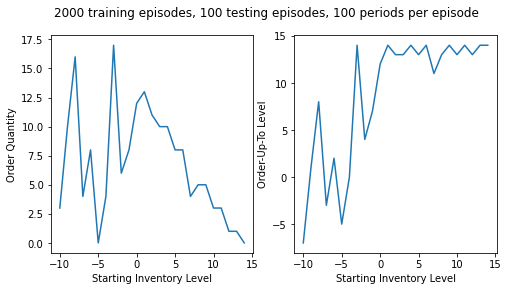

In [ ]:
# Plot policy.
title=f"{num_training_episodes} training episodes, {num_testing_episodes} testing episodes, {episode_length} periods per episode"
plot_policy(env=env, policy=pol, title=title)


If your RL agent performed similarly to mine, the plot is base-stock-ish, but not quite a base-stock policy. That's OK—we did a quicky and dirty training. More careful and longer training will result in a more accurate solution.

---
> If you wish, play around with the hyperparameters to try to improve the training process.
---

Let's also test the policy by playing a batch of episodes.

In [ ]:
# Test policy.
avg_reward = env.play_episode_batch(pol, num_testing_episodes)
print(f"Average reward per episode = {avg_reward}")


Average reward per episode = -183.2659817444024


Recall that the problem can be solved analytically. Let's compare the RL agent's solution with the analytical solution. The code below reports both the optimal expected cost per period and the corresponding expected discount cost over the horizon. 

The expected discounted horizon cost calculation uses the fact that, as in the "MPNV as MAB" notebook, we can convert an expected cost per period, $g$, to an expected discounte cost over $T$ time periods, as follows:

$$\sum_{t=0}^{T-1} g\gamma^i = g\frac{1 - \gamma^{T}}{1-\gamma}$$


In [ ]:
# Compare to analytical solution.
n = network.nodes[0]
opt_S, opt_cost = newsvendor_poisson(
    holding_cost=n.local_holding_cost,
    stockout_cost=n.stockout_cost,
    demand_mean=n.demand_source.mean
)
exp_disc_cost = opt_cost * (1 - env.gamma**episode_length) / (1 - env.gamma)
print(f"Optimal base-stock level = {opt_S} with expected cost per period = {opt_cost:.4f} and expected discounted horizon cost {exp_disc_cost:.4f}")


Optimal base-stock level = 8.0 with expected cost per period = 4.3432 and expected discounted horizon cost 86.8640


We can also simulate the system using `stockpyl` to get an average cost per period.

In [ ]:
# Simulate system. 
# First we have to specify the inventory policy that the node
# should use (base-stock with base-stock level 8).
from stockpyl.policy import Policy
network.nodes[0].inventory_policy = Policy(type='BS', base_stock_level=opt_S, node=network.nodes[0])
# Next, we have to implement a small tweak to account for a difference between
# our sequence of events and stockpyl's.
network.nodes[0].shipment_lead_time = 1
# Now do the simulation.
avg_sim_cost, _ = sim.run_multiple_trials(network, 10, 1000, progress_bar=False)
print(f"Average cost per period is {avg_sim_cost:4f}")

Average cost per period is 4.397600


To summarize:

In [ ]:
print(tabulate([
    ["Optimal base-stock level", opt_S],
    ["Average discounted reward per episode from environment play()", avg_reward],
    ["Optimal expected discounted reward per episode", exp_disc_cost],
    ["Optimal expected cost per period", opt_cost],
    ["Simulated average cost per period", avg_sim_cost]
]))

-------------------------------------------------------------  --------
Optimal base-stock level                                         8
Average discounted reward per episode from environment play()  -92.532
Optimal expected discounted reward per episode                  86.3498
Optimal expected cost per period                                 4.3432
Simulated average cost per period                                4.3976
-------------------------------------------------------------  --------


### If You Have Extra Time

As in the "MPNV as MDP" notebook, try adding a fixed cost $K$ to the environment. Train the RL algorithm using the same instance as before, plus $K=20$. Check whether the RL agent learned to follow an $(s,S)$ policy. 

Also use `stockpyl` to find the optimal $s$ and $S$, via the `s_s_discrete_exact()` function (see documentation [here](https://stockpyl.readthedocs.io/en/latest/api/seio/ss.html#stockpyl.ss.s_s_discrete_exact)). In particular, the following code solves the $(s,S)$ problem for a Poisson distribution with mean `mu`:

```python
from stockpyl.ss import s_s_discrete_exact
s, S, cost = s_s_discrete_exact(holding_cost=h, stockout_cost=p, fixed_cost=K, use_poisson=True, demand_mean=mu)
```

(Unfortunately, `stockpyl` cannot (yet) handle fixed costs in the simulation, so you can't simulate this system.)



---

Or: Suppose we have a finite time horizon, e.g., $T$ periods. We know that the optimal policy is a base-stock policy, and the base-stock levels are the parameters of that policy. Typically, those parameters are set using DP, but why not try out some policy gradient methods, like those that you implemented earlier in the workshop?